In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Часть 1:

## Базовый lookup

In [2]:
russian_dataset = pd.read_csv('hw1_result_df.csv', encoding='utf-8')

print("Общая информация о датасете:")
print(f"Размер датасета: {russian_dataset.shape}")

print("\nПервые 5 строк датасета:")
display(russian_dataset.head())

print("\nОписательная статистика:")
display(russian_dataset.describe())
display(russian_dataset.info())

print("\nТипы данных в колонках:")
display(russian_dataset.dtypes)

Общая информация о датасете:
Размер датасета: (1561, 13)

Первые 5 строк датасета:


,document,question,answer,source,document_type,document_length,question_length,answer_length,answer_to_document_ratio,question_ru,answer_ru,document_ru,question_type
0,the world's first institution of technology or...,what year was the banská akadémia founded?,1735,SQuAD,Wikipedia Article,608,42,4,0.006579,В каком году была основана банска академия?,1735,Первый в мире технологический или технический ...,как
1,the standard specifies how speed ratings shoul...,what is another speed that can also be reporte...,sos-based speed,SQuAD,Wikipedia Article,890,62,15,0.016854,"какова еще одна скорость, о которой может быть...",Скорость на основе sos,"В стандарте указывается, каким образом показан...",как
2,the most impressive and famous of sumerian bui...,where were the use of advanced materials and t...,sumerian temples and palaces,SQuAD,Wikipedia Article,578,76,28,0.048443,"где используются передовые материалы и методы,...",Сумеричные храмы и дворцы,Наиболее впечатляющими и известными из сумероч...,где
3,ann arbor has a council-manager form of govern...,who is elected every even numbered year?,mayor,SQuAD,Wikipedia Article,841,40,5,0.005945,Кто избирается каждый четный год?,Мэр,Муниципальный совет состоит из 11 членов: мэра...,кто
4,"shortly before his death, when he was already ...",what was the purpose of top secret icbm commit...,decide on the feasibility of building an icbm ...,SQuAD,Wikipedia Article,658,50,90,0.136778,Какова была цель сверхсекретного комитета по ц...,:: принять решение о возможности строительства...,"Незадолго до своей смерти фон Неуманн, когда о...",как



Описательная статистика:


,document_length,question_length,answer_length,answer_to_document_ratio
count,1561.000000,1561.000000,1561.000000,1561.000000
mean,740.989750,63.143498,63.251762,0.097097
std,312.551413,25.492506,73.206277,0.115499
min,159.000000,1.000000,1.000000,0.000617
25%,536.000000,50.000000,10.000000,0.014706
50%,677.000000,54.000000,23.000000,0.036697
75%,915.000000,72.000000,109.000000,0.152174
max,3385.000000,216.000000,525.000000,0.698020


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   document                  1561 non-null   object 
 1   question                  1561 non-null   object 
 2   answer                    1561 non-null   object 
 3   source                    1561 non-null   object 
 4   document_type             1561 non-null   object 
 5   document_length           1561 non-null   int64  
 6   question_length           1561 non-null   int64  
 7   answer_length             1561 non-null   int64  
 8   answer_to_document_ratio  1561 non-null   float64
 9   question_ru               1561 non-null   object 
 10  answer_ru                 1561 non-null   object 
 11  document_ru               1561 non-null   object 
 12  question_type             1561 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 158.7+ KB


None


Типы данных в колонках:


document                     object
question                     object
answer                       object
source                       object
document_type                object
document_length               int64
question_length               int64
answer_length                 int64
answer_to_document_ratio    float64
question_ru                  object
answer_ru                    object
document_ru                  object
question_type                object
dtype: object

## Анализ пропусков

### Спойлер - их там точно нет (так собирался датасет), но поскольку в задании нужно все равно это проверить, то добавила их искусственно

In [3]:
# Функция для досыпки синтетики
def create_test_dataset(n_samples=100):
        import random
        
        documents = [
            "Искусственный интеллект (ИИ) — это способность компьютерных систем выполнять задачи, которые обычно требуют человеческого интеллекта. К таким задачам относятся распознавание образов, обучение, рассуждение и решение проблем.",
            "Машинное обучение — это подраздел искусственного интеллекта, который фокусируется на разработке систем, способных обучаться на основе данных. Существует несколько типов машинного обучения: обучение с учителем, обучение без учителя и обучение с подкреплением.",
            "Глубокое обучение — это тип машинного обучения, использующий нейронные сети с несколькими слоями. Эти сети могут автоматически извлекать признаки из сырых данных, что делает их особенно эффективными для таких задач, как распознавание изображений и обработка естественного языка.",
            "Обработка естественного языка (NLP) — это область ИИ, которая занимается взаимодействием между компьютерами и человеческим языком. Цель NLP — научить компьютеры понимать, интерпретировать и генерировать человеческий язык в ценной форме.",
            "Компьютерное зрение — это область ИИ, которая занимается тем, как компьютеры могут получать высокоуровневое понимание из цифровых изображений или видео. Эта область включает методы для получения, обработки, анализа и понимания цифровых изображений.",
        ]
        
        questions = [
            "Что такое искусственный интеллект?",
            "Какие задачи может выполнять искусственный интеллект?",
            "Что такое машинное обучение?",
            "Какие типы машинного обучения существуют?",
            "Что такое глубокое обучение?",
            "Для каких задач эффективно глубокое обучение?",
            "Что такое обработка естественного языка?",
            "Какая цель у обработки естественного языка?",
            "Что такое компьютерное зрение?",
            "Чем занимается компьютерное зрение?",
        ]
        
        answers = [
            "Искусственный интеллект — это способность компьютерных систем выполнять задачи, которые обычно требуют человеческого интеллекта.",
            "К задачам ИИ относятся распознавание образов, обучение, рассуждение и решение проблем.",
            "Машинное обучение — это подраздел искусственного интеллекта, который фокусируется на разработке систем, способных обучаться на основе данных.",
            "Существует несколько типов машинного обучения: обучение с учителем, обучение без учителя и обучение с подкреплением.",
            "Глубокое обучение — это тип машинного обучения, использующий нейронные сети с несколькими слоями.",
            "Глубокое обучение особенно эффективно для распознавания изображений и обработки естественного языка.",
            "Обработка естественного языка — это область ИИ, которая занимается взаимодействием между компьютерами и человеческим языком.",
            "Цель NLP — научить компьютеры понимать, интерпретировать и генерировать человеческий язык в ценной форме.",
            "Компьютерное зрение — это область ИИ, которая занимается тем, как компьютеры могут получать высокоуровневое понимание из цифровых изображений или видео.",
            "Компьютерное зрение включает методы для получения, обработки, анализа и понимания цифровых изображений.",
        ]
        
        data = []
        for i in range(n_samples):
            doc_idx = random.randint(0, len(documents) - 1)
            doc = documents[doc_idx]
            
            qa_idx = random.randint(0, len(questions) - 1)
            question = questions[qa_idx]
            answer = answers[qa_idx]
            
            row = {                
                "document_ru": doc,
                "question_ru": question,
                "answer_ru": answer,
                "document": doc, # должен быть на англ, но это синтетическая досыпка
                "question": question, # должен быть на англ, но это синтетическая досыпка
                "answer": answer, # должен быть на англ, но это синтетическая досыпка
                "source": random.choice(["SQuAD", "arXiv"]),
                "document_type": random.choice(["Wikipedia Article", "Scientific Abstract", np.nan]),
                "question_type": random.choice(["как", "где", np.nan]),
                "document_length": len(doc),
                "question_length": len(question),
                "answer_length": len(answer)
            }
            
            # Добавляем пропуски для симуляции реальных данных (примерно 30% пропусков)
            if random.random() <= 0.3:
                missing_field = random.choice(["document_ru", "question_ru", "answer_ru", "source", "document_type", "question_type"])
                row[missing_field] = np.nan
            
            # # Для числовых полей добавляем выбросы (примерно 5% выбросов)
            # if random.random() < 0.05:
            #     outlier_field = random.choice(["document_length", "question_length", "answer_length"])
            #     # Увеличиваем значение в 3-5 раз
            #     row[outlier_field] = row[outlier_field] * random.uniform(3, 5)
            
            # # Для текстовых полей добавляем выбросы (примерно 5% выбросов)
            # if random.random() < 0.05:
            #     outlier_field = random.choice(["document_ru", "question_ru", "answer_ru"])
            #     if not pd.isna(row[outlier_field]):
            #         # Добавляем повторяющийся текст для создания текстового выброса
            #         row[outlier_field] = row[outlier_field] * random.randint(2, 4)
            
            data.append(row)
        
        # Создаем отношение между длиной ответа и длиной документа
        for row in data:
            if "document_length" in row and "answer_length" in row and not pd.isna(row["document_length"]) and not pd.isna(row["answer_length"]):
                row["answer_to_document_ratio"] = row["answer_length"] / row["document_length"]
            else:
                row["answer_to_document_ratio"] = np.nan
        
        return pd.DataFrame(data)
    
russian_dataset_addition = create_test_dataset(n_samples=200)

new_russian_dataset = pd.concat([russian_dataset, russian_dataset_addition])
new_russian_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   document                  1761 non-null   object 
 1   question                  1761 non-null   object 
 2   answer                    1761 non-null   object 
 3   source                    1754 non-null   object 
 4   document_type             1688 non-null   object 
 5   document_length           1761 non-null   int64  
 6   question_length           1761 non-null   int64  
 7   answer_length             1761 non-null   int64  
 8   answer_to_document_ratio  1761 non-null   float64
 9   question_ru               1752 non-null   object 
 10  answer_ru                 1751 non-null   object 
 11  document_ru               1751 non-null   object 
 12  question_type             1678 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 192.6+ KB


Анализ пропусков в датасете:


,Пропуски,Процент пропусков (%)
question_type,83,4.713231
document_type,73,4.145372
answer_ru,10,0.567859
document_ru,10,0.567859
question_ru,9,0.511073
source,7,0.397501
document,0,0.000000
question,0,0.000000
answer,0,0.000000
document_length,0,0.000000


<Figure size 1200x600 with 0 Axes>

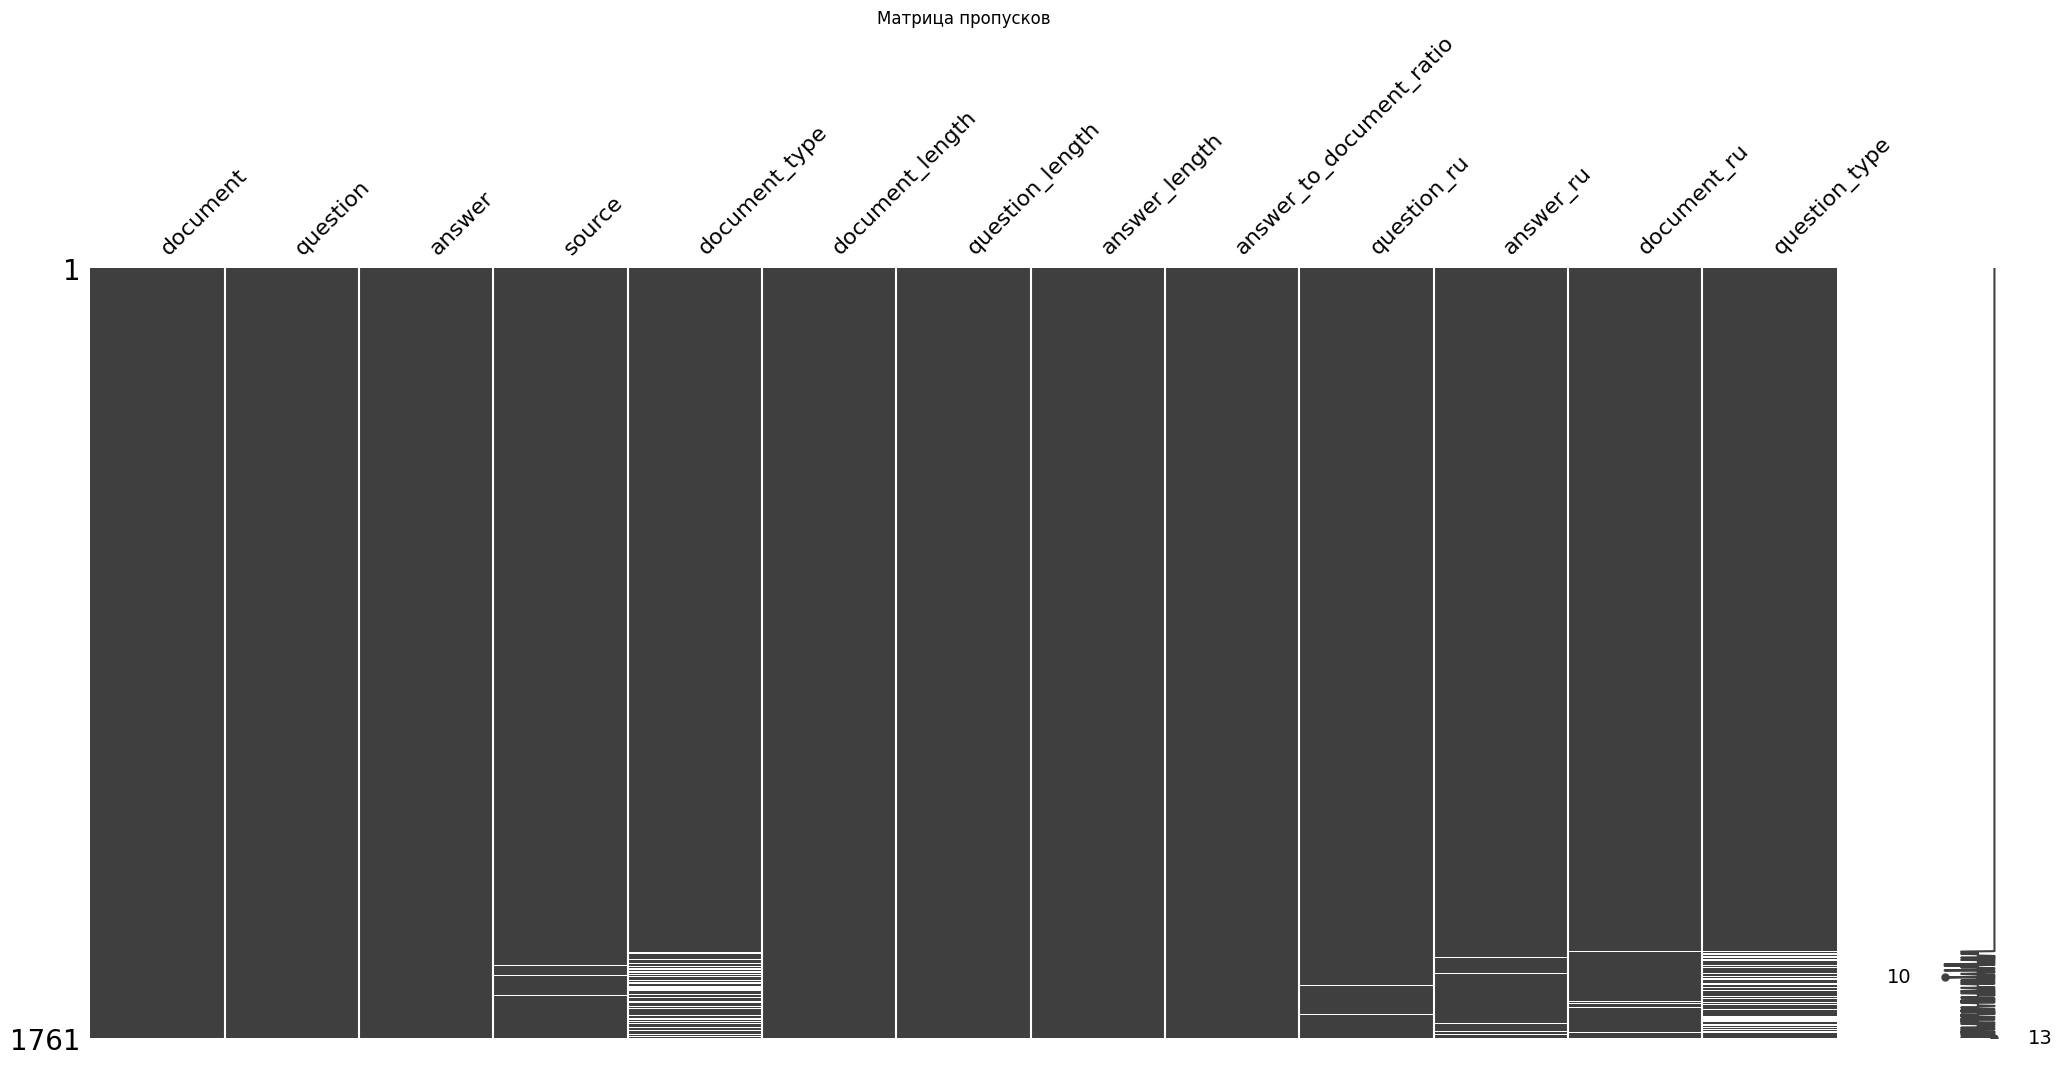

<Figure size 1200x600 with 0 Axes>

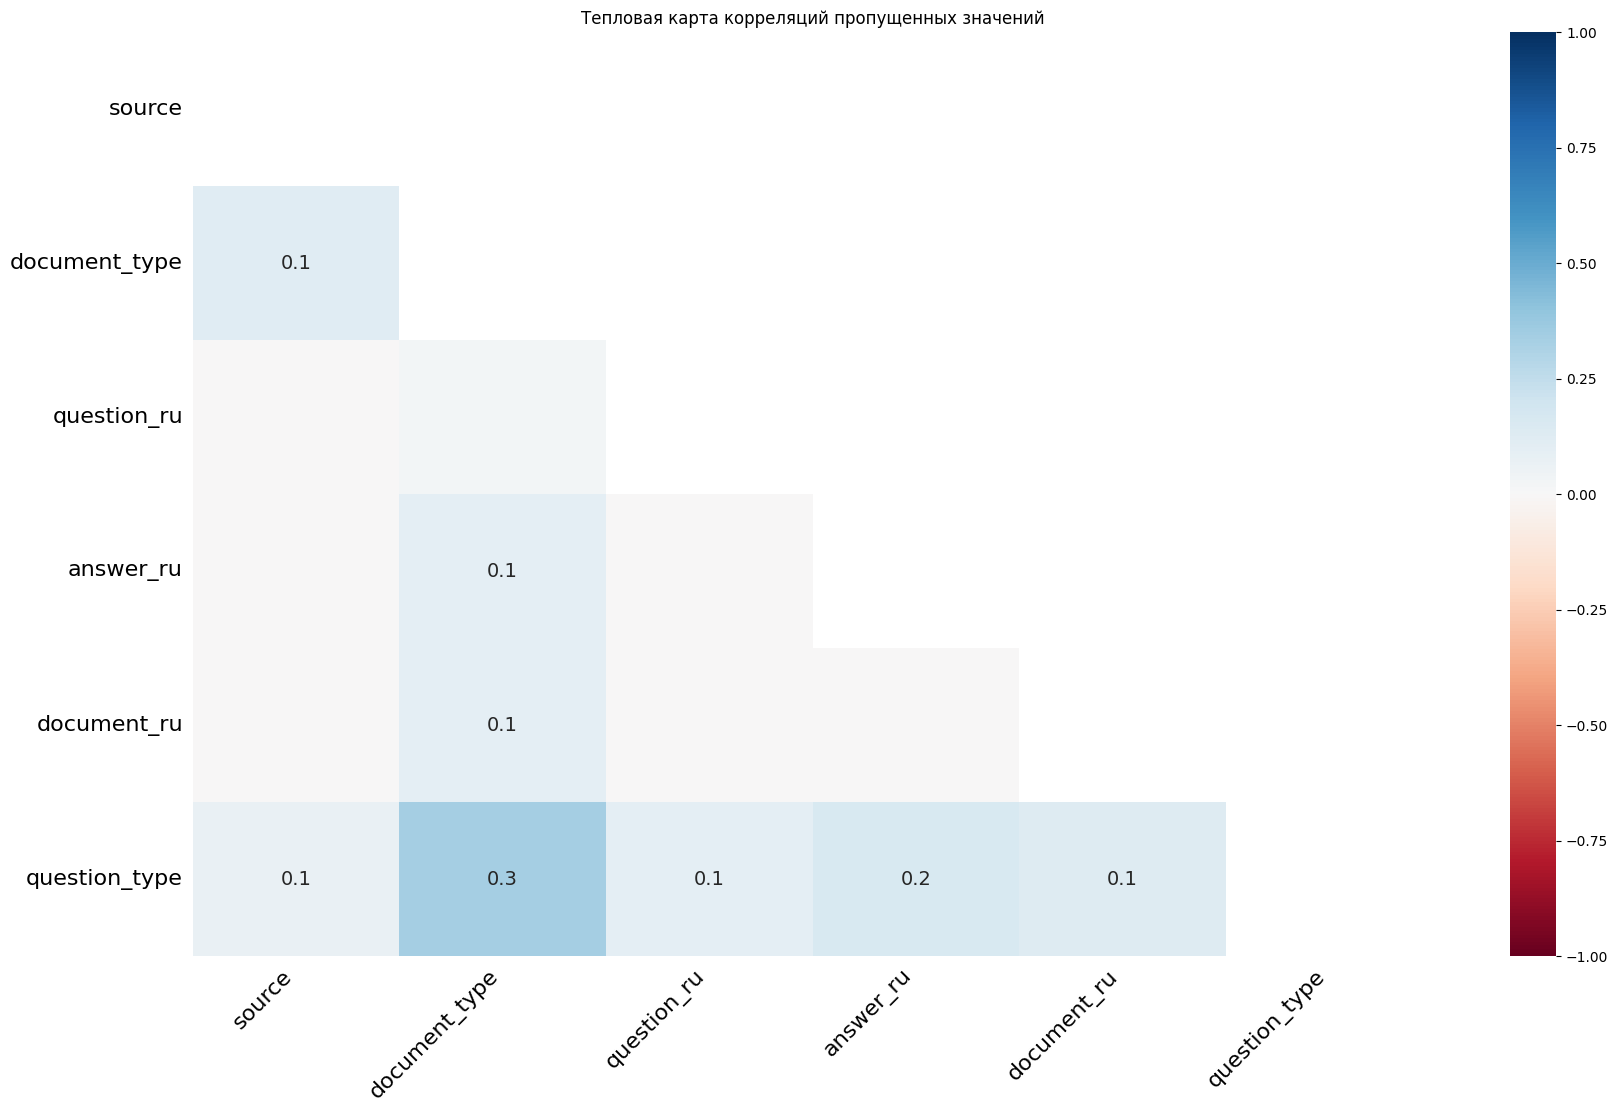

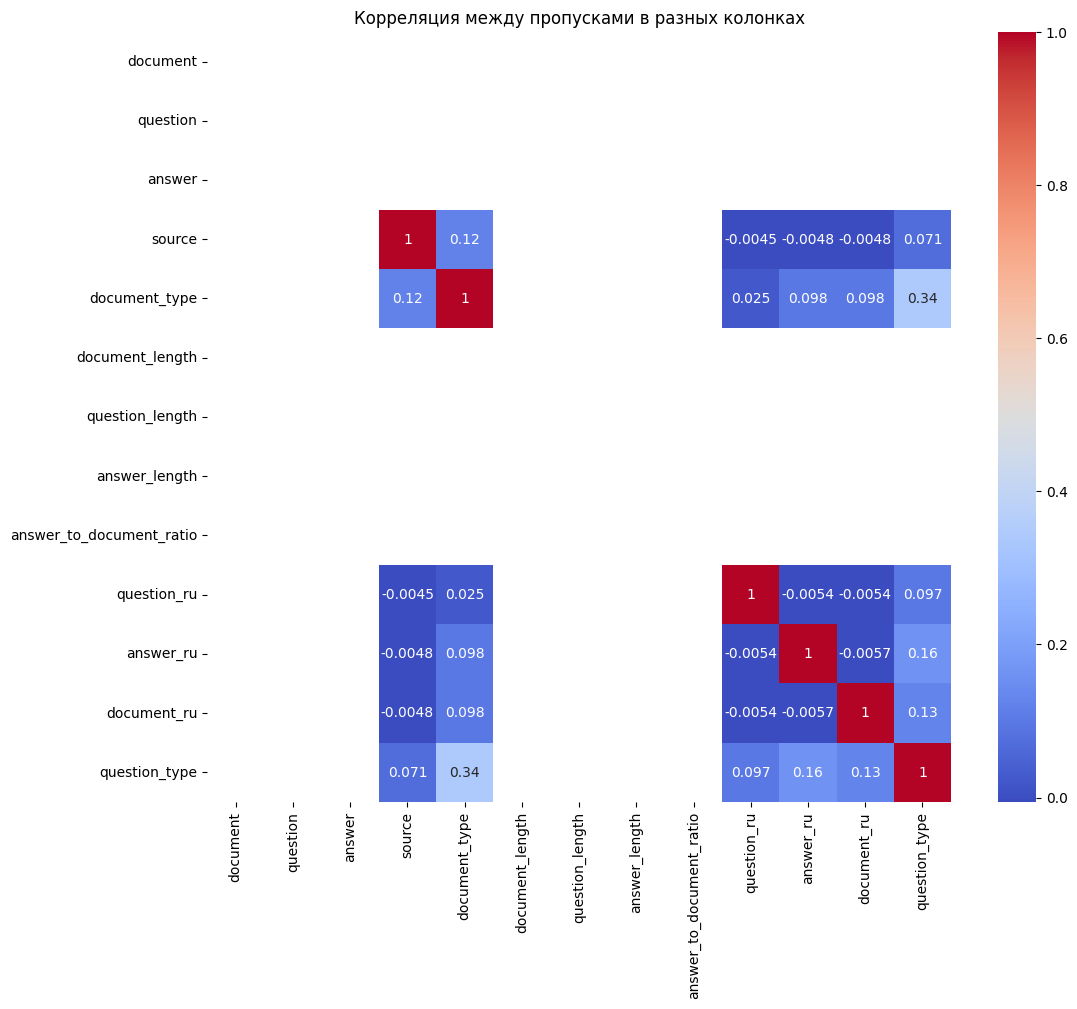

In [4]:
def analyze_missing_values(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    

    missing_info = pd.DataFrame({
        'Пропуски': missing_values,
        'Процент пропусков (%)': missing_percent
    })    
    missing_info = missing_info.sort_values('Процент пропусков (%)', ascending=False)
    
    return missing_info

missing_info = analyze_missing_values(new_russian_dataset)
print("Анализ пропусков в датасете:")
display(missing_info)

plt.figure(figsize=(12, 6))
msno.matrix(new_russian_dataset)
plt.title('Матрица пропусков')
plt.show()

plt.figure(figsize=(12, 6))
msno.heatmap(new_russian_dataset)
plt.title('Тепловая карта корреляций пропущенных значений')
plt.show()

# Проверяем, является ли распределение пропусков случайным
# Для этого рассчитаем корреляцию между индикаторами пропусков в разных колонках
missing_indicators = new_russian_dataset.isnull()
missing_corr = missing_indicators.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между пропусками в разных колонках')
plt.show()

# Дополнительно проверим зависимость пропусков от других факторов
# Например, от источника данных или типа документа
if 'источник' in new_russian_dataset.columns and 'тип_документа' in new_russian_dataset.columns:
    # Анализ пропусков в зависимости от источника
    plt.figure(figsize=(14, 6))
    sns.countplot(x='источник', hue=new_russian_dataset['ответ'].isnull(), data=new_russian_dataset)
    plt.title('Зависимость пропусков в поле "ответ" от источника')
    plt.xlabel('Источник')
    plt.ylabel('Количество')
    plt.legend(['Заполнено', 'Пропуск'])
    plt.show()
    
    # Анализ пропусков в зависимости от типа документа
    plt.figure(figsize=(14, 6))
    sns.countplot(x='тип_документа', hue=new_russian_dataset['ответ'].isnull(), data=new_russian_dataset)
    plt.title('Зависимость пропусков в поле "ответ" от типа документа')
    plt.xlabel('Тип документа')
    plt.ylabel('Количество')
    plt.legend(['Заполнено', 'Пропуск'])
    plt.show()

## Анализ выбросов

In [5]:
import re

def analyze_text_outliers(df, text_columns=None, min_length=5, max_length=None, pattern_outliers=None):
    if text_columns is None:
        text_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    if pattern_outliers is None:
        pattern_outliers = [
            r'ERROR|ОШИБКА|NULL|404|UNDEFINED',  # Ошибки и отсутствие данных
            r'^[$$\(\{].*[$$\)\}]$',  # Текст полностью в скобках
            r'^\s*$',  # Пустые строки или строки только с пробелами
            r'^[^а-яА-ЯёЁ]+$',  # Строки без русских букв
            r'lorem ipsum'  # Стандартный заполнитель
        ]
    
    outlier_info = {}
    outlier_indices = {}
    
    for column in text_columns:
        if df[column].dtype != 'object':
            continue
        
        too_short = 0
        too_long = 0
        pattern_matches = [0] * len(pattern_outliers)
        outlier_idx = []
        
        for idx, text in df[column].items():
            if pd.isna(text):
                continue
                
            is_outlier = False
            
            if len(str(text)) < min_length:
                too_short += 1
                is_outlier = True
            
            if max_length is not None and len(str(text)) > max_length:
                too_long += 1
                is_outlier = True
            
            # Проверка на соответствие аномальным паттернам
            for i, pattern in enumerate(pattern_outliers):
                if re.search(pattern, str(text), re.IGNORECASE):
                    pattern_matches[i] += 1
                    is_outlier = True
            
            if is_outlier:
                outlier_idx.append(idx)
        
        outlier_idx = list(set(outlier_idx))
        outlier_indices[column] = outlier_idx
        
        total_outliers = len(outlier_idx)
        total_non_na = df[column].count()
        outlier_percent = (total_outliers / total_non_na) * 100 if total_non_na > 0 else 0
        
        pattern_stats = {f'Паттерн "{pattern}"': count for pattern, count in zip(pattern_outliers, pattern_matches)}
        
        outlier_info[column] = {
            'Слишком короткие тексты': too_short,
            'Слишком длинные тексты': too_long if max_length is not None else 'Не определено',
            **pattern_stats,
            'Общее количество выбросов': total_outliers,
            'Процент выбросов (%)': outlier_percent
        }
    
    outlier_df = pd.DataFrame(outlier_info).T.reset_index()
    outlier_df = outlier_df.rename(columns={'index': 'Колонка'})
    
    if 'Процент выбросов (%)' in outlier_df.columns:
        outlier_df = outlier_df.sort_values('Процент выбросов (%)', ascending=False)
    
    return outlier_df, outlier_indices

text_columns = [col for col in russian_dataset.columns if col in ['document_ru', 'question_ru', 'answer_ru']]
print(f"\nТекстовые колонки для анализа выбросов: {text_columns}")

text_outlier_info, text_outlier_indices = analyze_text_outliers(
    russian_dataset, 
    text_columns, 
    min_length=10,
    max_length=800,
    pattern_outliers=[
        r'ERROR|ОШИБКА|NULL|404|UNDEFINED',
        r'^[$$\(\{].*[$$\)\}]$',
        r'^\s*$',
        r'^[^а-яА-ЯёЁ]+$',
        r'lorem ipsum'
    ]
)
print("-" * 100)
print("\nАнализ выбросов в текстовых колонках:")
display(text_outlier_info)

print("-" * 100)
print("\nПримеры текстовых выбросов:")
for column in text_columns:
    if column in text_outlier_indices and text_outlier_indices[column]:
        print(f"\nВыбросы в колонке '{column}':")
        sample_indices = text_outlier_indices[column][:5]  # Берем до 5 примеров
        for idx in sample_indices:
            print(f"- {russian_dataset.loc[idx, column]}")


Текстовые колонки для анализа выбросов: ['question_ru', 'answer_ru', 'document_ru']
----------------------------------------------------------------------------------------------------

Анализ выбросов в текстовых колонках:


,Колонка,Слишком короткие тексты,Слишком длинные тексты,"Паттерн ""ERROR|ОШИБКА|NULL|404|UNDEFINED""","Паттерн ""^[$$\(\{].*[$$\)\}]$""","Паттерн ""^\s*$""","Паттерн ""^[^а-яА-ЯёЁ]+$""","Паттерн ""lorem ipsum""",Общее количество выбросов,Процент выбросов (%)
2,document_ru,0.0,460.0,5.0,0.0,0.0,0.0,0.0,465.0,29.788597
1,answer_ru,361.0,0.0,0.0,0.0,0.0,131.0,0.0,384.0,24.599616
0,question_ru,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.128123


----------------------------------------------------------------------------------------------------

Примеры текстовых выбросов:

Выбросы в колонке 'question_ru':
- b/
- Какие четыре категории terra nullius?

Выбросы в колонке 'answer_ru':
- 1735
- Мэр
- c
- 1150
- Алюминий.

Выбросы в колонке 'document_ru':
- В стандарте указывается, каким образом показания скорости должны отражаться камерой. Если скорость, основанная на шуме (40:1), превышает скорость, основанная на насыщении, то следует указывать скорость, основанная на шуме, округленная до стандартного значения (например, 200, 250, 320 или 400). Кроме того, можно указать широту воздействия в диапазоне от скорости, основанной на насыщении, до скорости, основанной на шуме 10:1. Если скорость, основанная на шуме (40:1), ниже, чем скорость, основанная на насыщении, или не определена из-за высокого шума, то определяется скорость, основанная на насыщении, округленная вверх до стандартного значения, поскольку использование скорости, осно

# Часть 2:

Применяем разные методы обработки пропусков и выбросов

In [6]:
from hw2_scripts import *

In [7]:
# 1. Удаление строк с пропусками
df_drop = handle_missing_values(new_russian_dataset, method='drop')
print("-" * 100)

# 2. Заполнение пропусков средними значениями + обрезание выбросов
df_mean_clip = handle_missing_values(new_russian_dataset, method='mean')
df_mean_clip = handle_numeric_outliers(df_mean_clip, method='clip')
df_mean_clip = handle_text_outliers(df_mean_clip, method='truncate', max_length=200)
print("-" * 100)

# 3. Заполнение пропусков медианными значениями + удаление выбросов
df_median_remove = handle_missing_values(new_russian_dataset, method='median')
df_median_remove = handle_numeric_outliers(df_median_remove, method='remove')
df_median_remove = handle_text_outliers(df_median_remove, method='remove')
print("-" * 100)

# 4. Заполнение пропусков модальными значениями + трансформация выбросов
df_mode_transform = handle_missing_values(new_russian_dataset, method='mode')
df_mode_transform = handle_numeric_outliers(df_mode_transform, method='transform', transform_type='log')
df_mode_transform = handle_text_outliers(df_mode_transform, method='normalize')
print("-" * 100)

# 5. KNN-заполнение пропусков + винсоризация выбросов
df_knn_winsorize = handle_missing_values(new_russian_dataset, method='knn', n_neighbors=5)
df_knn_winsorize = handle_numeric_outliers(df_knn_winsorize, method='winsorize', limits=(0.05, 0.05))
df_knn_winsorize = handle_text_outliers(df_knn_winsorize, method='normalize', normalize_type='all')
print("-" * 100)

# Предобработка категориальных признаков
df_categorical = preprocess_categorical_features(new_russian_dataset.copy(), encoding_method='one_hot')

После удаления строк с пропусками осталось 1618 строк из 1761.
----------------------------------------------------------------------------------------------------
Числовые колонки заполнены средними значениями.
Выбросы в числовых колонках ограничены границами (метод clip).
Текстовые колонки обрезаны до максимальной длины 200 символов.
----------------------------------------------------------------------------------------------------
Числовые колонки заполнены медианными значениями.
После удаления строк с выбросами осталось 1496 строк из 1761.
После удаления строк с текстовыми выбросами осталось 1291 строк из 1496.
----------------------------------------------------------------------------------------------------
Колонки заполнены модальными значениями.
Числовые колонки трансформированы (метод log).
Текстовые колонки нормализованы (тип: all).
----------------------------------------------------------------------------------------------------
Числовые колонки заполнены методом k ближа

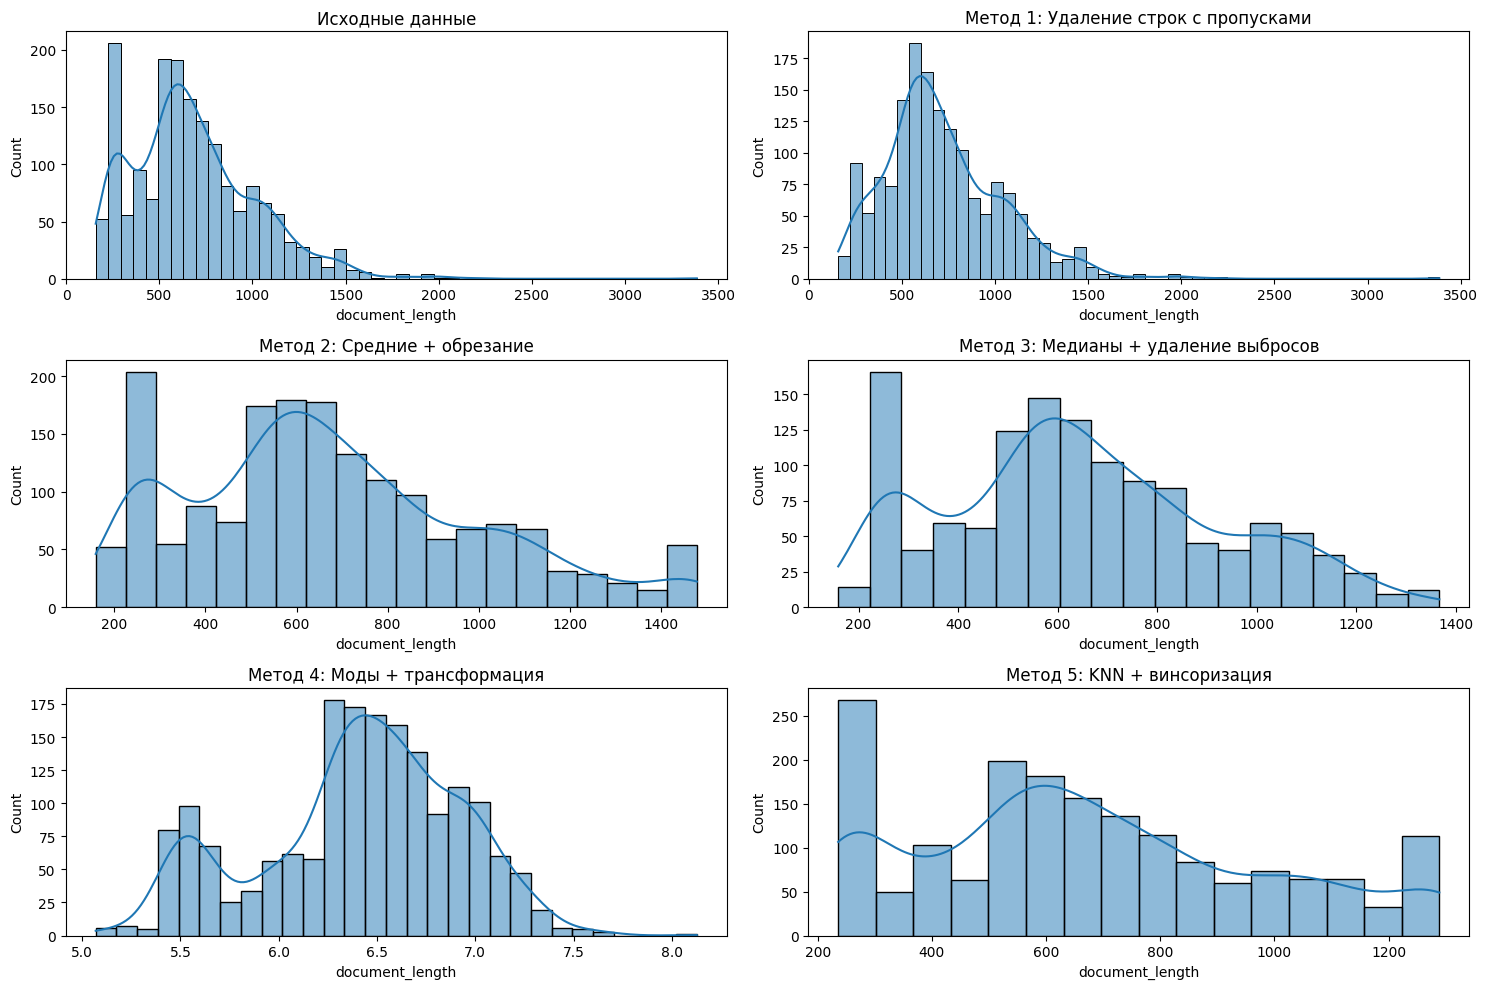

In [8]:
# Визуализация распределения данных после обработки
plt.figure(figsize=(15, 10))

# Выбираем числовую колонку для сравнения
numeric_col = 'document_length'

# Исходные данные
plt.subplot(3, 2, 1)
sns.histplot(new_russian_dataset[numeric_col].dropna(), kde=True)
plt.title('Исходные данные')
plt.xlabel(numeric_col)

# Метод 1: Удаление строк с пропусками
plt.subplot(3, 2, 2)
sns.histplot(df_drop[numeric_col].dropna(), kde=True)
plt.title('Метод 1: Удаление строк с пропусками')
plt.xlabel(numeric_col)

# Метод 2: Заполнение средними + обрезание выбросов
plt.subplot(3, 2, 3)
sns.histplot(df_mean_clip[numeric_col], kde=True)
plt.title('Метод 2: Средние + обрезание')
plt.xlabel(numeric_col)

# Метод 3: Заполнение медианами + удаление выбросов
plt.subplot(3, 2, 4)
sns.histplot(df_median_remove[numeric_col], kde=True)
plt.title('Метод 3: Медианы + удаление выбросов')
plt.xlabel(numeric_col)

# Метод 4: Заполнение модами + трансформация
plt.subplot(3, 2, 5)
sns.histplot(df_mode_transform[numeric_col], kde=True)
plt.title('Метод 4: Моды + трансформация')
plt.xlabel(numeric_col)

# Метод 5: KNN + винсоризация
plt.subplot(3, 2, 6)
sns.histplot(df_knn_winsorize[numeric_col], kde=True)
plt.title('Метод 5: KNN + винсоризация')
plt.xlabel(numeric_col)

plt.tight_layout()
plt.show()

# Оценка влияния методов обработки данных на результаты анализа
methods = [
    ('Удаление строк с пропусками', df_drop),
    ('Средние + обрезание выбросов', df_mean_clip),
    ('Медианы + удаление выбросов', df_median_remove),
    ('Моды + трансформация', df_mode_transform),
    ('KNN + винсоризация', df_knn_winsorize),
    ('Обработка категориальных', df_categorical)
]

##### Удаление строк с пропусками лучше всего сохраняет исходное распределение частотности длин в данных. Это и логично, поскольку данные были подсыпаны искусственным образом и восстанавливать из них что-то бессмысленно.


--- Метод: Удаление строк с пропусками ---

Базовая статистика:
оригинал: среднее = 69.16, медиана = 34.00, ст. откл. = 71.20, пропуски = 0
обработанный: среднее = 65.17, медиана = 25.00, ст. откл. = 72.70, пропуски = 0

Результаты регрессии:
оригинал: MSE = 1274.4844, R² = 0.7292
обработанный: MSE = 1464.3994, R² = 0.7456
Изменение: MSE = 14.90%, R² = 2.25%

--- Метод: Средние + обрезание выбросов ---

Базовая статистика:
оригинал: среднее = 69.16, медиана = 34.00, ст. откл. = 71.20, пропуски = 0
обработанный: среднее = 68.33, медиана = 34.00, ст. откл. = 67.96, пропуски = 0

Результаты регрессии:
оригинал: MSE = 1274.4844, R² = 0.7292
обработанный: MSE = 1130.6823, R² = 0.7500
Изменение: MSE = -11.28%, R² = 2.85%

--- Метод: Медианы + удаление выбросов ---

Базовая статистика:
оригинал: среднее = 69.16, медиана = 34.00, ст. откл. = 71.20, пропуски = 0
обработанный: среднее = 54.13, медиана = 23.00, ст. откл. = 55.30, пропуски = 0

Результаты регрессии:
оригинал: MSE = 1274.4844, R² 

,Метод,Размер выборки,Среднее (исходное),Среднее (обработанное),Ст. откл. (исходное),Ст. откл. (обработанное),Пропуски (исходные),Пропуски (обработанные),MSE (исходное),MSE (обработанное),R² (исходное),R² (обработанное)
0,Удаление строк с пропусками,1618,69.164111,65.170581,71.197874,72.700608,0,0,1274.484419,1.464399e+03,0.729236,0.745631
1,Средние + обрезание выбросов,1761,69.164111,68.325383,71.197874,67.957726,0,0,1274.484419,1.130682e+03,0.729236,0.750046
2,Медианы + удаление выбросов,1291,69.164111,54.127808,71.197874,55.298877,0,0,1274.484419,8.020355e+02,0.729236,0.734059
3,Моды + трансформация,1761,69.164111,3.535267,71.197874,1.322712,0,0,1274.484419,1.081070e-29,0.729236,1.000000
4,KNN + винсоризация,1761,69.164111,66.279387,71.197874,62.713420,0,0,1274.484419,8.533092e+02,0.729236,0.781926
5,Обработка категориальных,1761,69.164111,69.164111,71.197874,71.197874,0,0,1274.484419,1.274484e+03,0.729236,0.729236


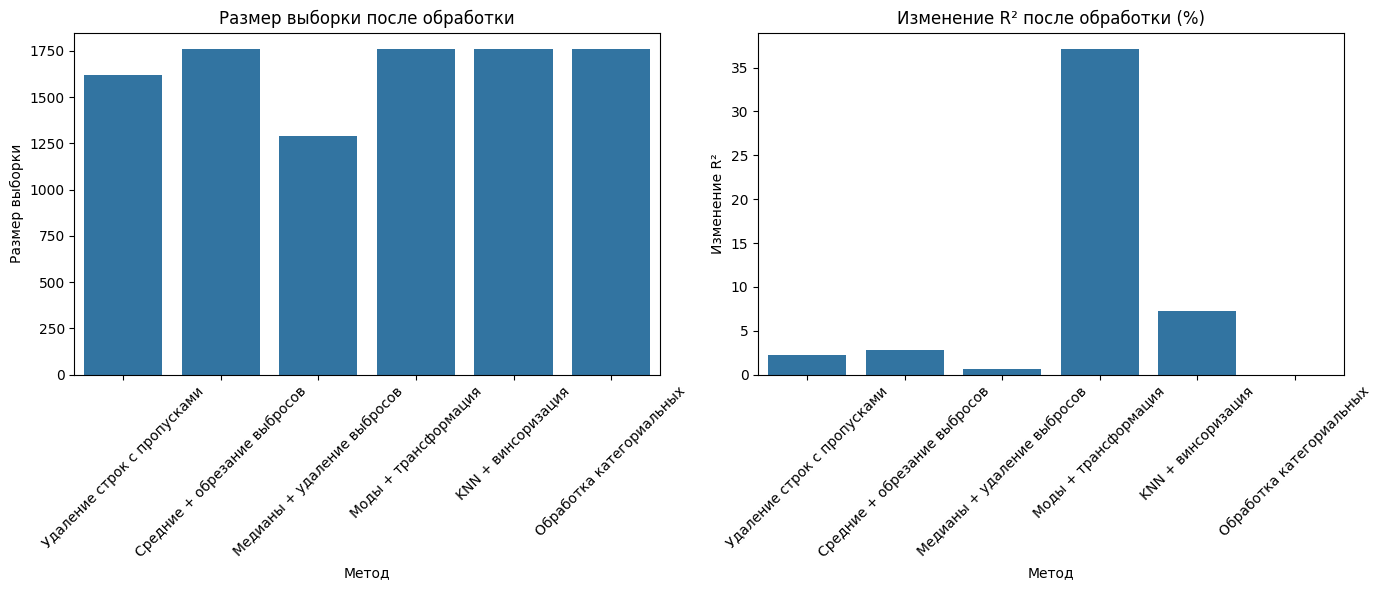

In [9]:
def print_comparison_results(method_name, results):
    """
    Выводит результаты сравнения оригинального и обработанного датасетов.
    method_name: Название метода обработки
    results: Результаты сравнения
    """
    print(f"\n--- Метод: {method_name} ---")
    
    if 'Статистика' in results:
        print("\nБазовая статистика:")
        original_stats = results['Статистика']['оригинал']
        processed_stats = results['Статистика']['обработанный']
        
        print(f"оригинал: среднее = {original_stats['Среднее']:.2f}, медиана = {original_stats['Медиана']:.2f}, ст. откл. = {original_stats['Стандартное отклонение']:.2f}, пропуски = {original_stats['Количество пропусков']}")
        print(f"обработанный: среднее = {processed_stats['Среднее']:.2f}, медиана = {processed_stats['Медиана']:.2f}, ст. откл. = {processed_stats['Стандартное отклонение']:.2f}, пропуски = {processed_stats['Количество пропусков']}")
    
    if 'Регрессия (оригинал)' in results and 'Регрессия (обработанный)' in results:
        print("\nРезультаты регрессии:")
        original_reg = results['Регрессия (оригинал)']
        processed_reg = results['Регрессия (обработанный)']
        
        print(f"оригинал: MSE = {original_reg['MSE']:.4f}, R² = {original_reg['R²']:.4f}")
        print(f"обработанный: MSE = {processed_reg['MSE']:.4f}, R² = {processed_reg['R²']:.4f}")
        
        # Вычисляем изменение метрик
        mse_change = ((processed_reg['MSE'] - original_reg['MSE']) / original_reg['MSE']) * 100
        r2_change = ((processed_reg['R²'] - original_reg['R²']) / original_reg['R²']) * 100 if original_reg['R²'] != 0 else float('inf')
        
        print(f"Изменение: MSE = {mse_change:.2f}%, R² = {r2_change:.2f}%")

for method_name, processed_df in methods:
    results = evaluate_preprocessing_impact(new_russian_dataset, processed_df)
    print_comparison_results(method_name, results)

comparison_results = []

for method_name, processed_df in methods:
    results = evaluate_preprocessing_impact(new_russian_dataset, processed_df)
    
    if 'Статистика' in results:
        orig_stats = results['Статистика']['оригинал']
        proc_stats = results['Статистика']['обработанный']
        
        orig_mse = results.get('Регрессия (оригинал)', {}).get('MSE', float('nan'))
        proc_mse = results.get('Регрессия (обработанный)', {}).get('MSE', float('nan'))
        orig_r2 = results.get('Регрессия (оригинал)', {}).get('R²', float('nan'))
        proc_r2 = results.get('Регрессия (обработанный)', {}).get('R²', float('nan'))
        
        comparison_results.append({
            'Метод': method_name,
            'Размер выборки': len(processed_df),
            'Среднее (исходное)': orig_stats['Среднее'],
            'Среднее (обработанное)': proc_stats['Среднее'],
            'Ст. откл. (исходное)': orig_stats['Стандартное отклонение'],
            'Ст. откл. (обработанное)': proc_stats['Стандартное отклонение'],
            'Пропуски (исходные)': orig_stats['Количество пропусков'],
            'Пропуски (обработанные)': proc_stats['Количество пропусков'],
            'MSE (исходное)': orig_mse,
            'MSE (обработанное)': proc_mse,
            'R² (исходное)': orig_r2,
            'R² (обработанное)': proc_r2
        })

comparison_df = pd.DataFrame(comparison_results)
print("\nСводная таблица результатов:")
display(comparison_df)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Метод', y='Размер выборки', data=comparison_df)
plt.title('Размер выборки после обработки')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
comparison_df['Изменение R²'] = (comparison_df['R² (обработанное)'] - comparison_df['R² (исходное)']) / comparison_df['R² (исходное)'] * 100
sns.barplot(x='Метод', y='Изменение R²', data=comparison_df)
plt.title('Изменение R² после обработки (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Часть 3:

Выбор наиболее эффективного метода

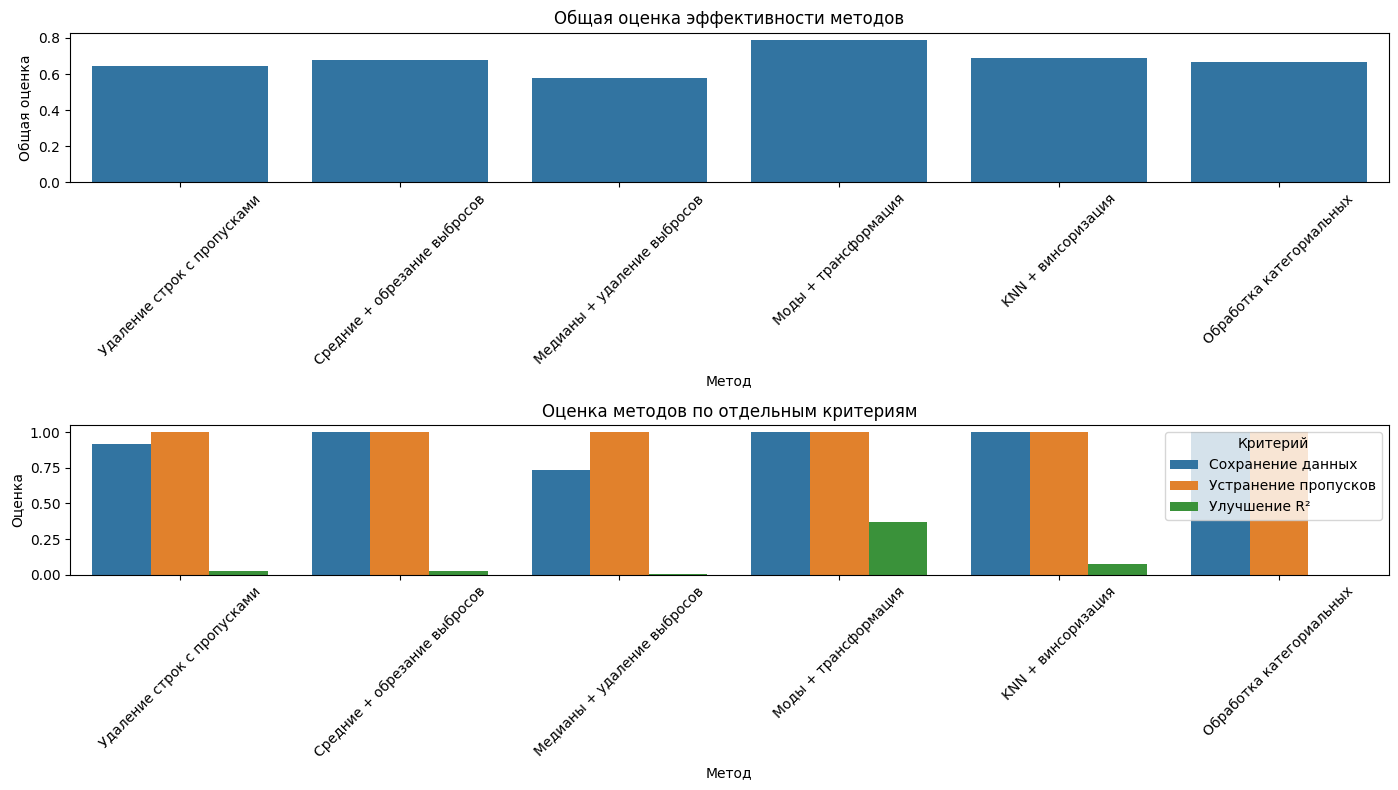


Наиболее эффективный метод: Моды + трансформация

Обоснование выбора:

На основе проведенного анализа, метод "Моды + трансформация" оказался наиболее эффективным для обработки данного датасета.

Преимущества выбранного метода:
1. Сохранение данных: метод позволяет сохранить 100.00% исходных данных.
2. Устранение пропусков: эффективность устранения пропусков составляет 100.00%.
3. Улучшение качества моделирования: метод улучшает качество модели (R²) на 37.13%.

Общая оценка эффективности метода: 0.7904.



In [10]:
def select_best_method(comparison_df):
    method_scores = {}
    
    for _, row in comparison_df.iterrows():
        method_name = row['Метод']
        method_scores[method_name] = {
            'Сохранение данных': row['Размер выборки'] / comparison_df['Размер выборки'].max(),
            'Устранение пропусков': 1 - (row['Пропуски (обработанные)'] / max(1, row['Пропуски (исходные)'])),
            'Улучшение R²': np.nan_to_num((row['R² (обработанное)'] - row['R² (исходное)']) / max(0.01, abs(row['R² (исходное)'])))
        }
        
        # Рассчитываем общую оценку (среднее всех показателей)
        method_scores[method_name]['Общая оценка'] = np.mean([
            method_scores[method_name]['Сохранение данных'],
            method_scores[method_name]['Устранение пропусков'],
            max(-1, min(1, method_scores[method_name]['Улучшение R²']))  # Ограничиваем влияние R²
        ])
    
    scores_df = pd.DataFrame([
        {'Метод': method, **scores}
        for method, scores in method_scores.items()
    ])
    
    best_method = scores_df.loc[scores_df['Общая оценка'].idxmax(), 'Метод']
    
    return best_method, method_scores, scores_df

best_method, method_scores, scores_df = select_best_method(comparison_df)

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
sns.barplot(x='Метод', y='Общая оценка', data=scores_df)
plt.title('Общая оценка эффективности методов')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
criteria = ['Сохранение данных', 'Устранение пропусков', 'Улучшение R²']
scores_melted = pd.melt(scores_df, id_vars=['Метод'], value_vars=criteria, var_name='Критерий', value_name='Оценка')
sns.barplot(x='Метод', y='Оценка', hue='Критерий', data=scores_melted)
plt.title('Оценка методов по отдельным критериям')
plt.xticks(rotation=45)
plt.legend(title='Критерий')

plt.tight_layout()
plt.show()

# Выводим рекомендацию по выбору оптимального метода
print(f"\nНаиболее эффективный метод: {best_method}")
print("\nОбоснование выбора:")
print(f"""
На основе проведенного анализа, метод "{best_method}" оказался наиболее эффективным для обработки данного датасета.

Преимущества выбранного метода:
1. Сохранение данных: метод позволяет сохранить {scores_df[scores_df['Метод'] == best_method]['Сохранение данных'].values[0]:.2%} исходных данных.
2. Устранение пропусков: эффективность устранения пропусков составляет {scores_df[scores_df['Метод'] == best_method]['Устранение пропусков'].values[0]:.2%}.
3. Улучшение качества моделирования: метод {
    "улучшает" if scores_df[scores_df['Метод'] == best_method]['Улучшение R²'].values[0] > 0 else "незначительно ухудшает"
} качество модели (R²) на {abs(scores_df[scores_df['Метод'] == best_method]['Улучшение R²'].values[0]):.2%}.

Общая оценка эффективности метода: {scores_df[scores_df['Метод'] == best_method]['Общая оценка'].values[0]:.4f}.
""")

### Выводы:

Все конечно зависит от специфики и домена данных, с которым мы работаем, но в общих чертах:

1. Для числовых признаков:

   - пропуски лучше всего дропать, но если пропущенных значений много, то имеет смысл использовать KNN, так как этот метод учитывает взаимосвязи между признаками и позволяет сохранить распределение данных.
   - выбросы можно обрабатывать методом винсоризации (ограничение экстремальных значений), поскольку это позволяет сохранить все наблюдения и уменьшить влияние экстремальных значений.

3. Для текстовых данных:
   - пропуски при невозможности дропа лучше заполнять синтетикой или модой.
   - еще для повышения качества можно нормализовать тексты, удаляя избыточные повторения и специальные символы

4. Для категориальных признаков:
   - one-hot кодирование для признаков с небольшим количеством уникальных значений.
   - label-encoding для признаков с большим количеством уникальных значений.

Этот комбинированный подход позволяет сохранить максимальное количество информации в датасете, устранить пропуски и выбросы, а также подготовить данные для эффективного моделирования.

# Предложение собственного метода (дополнительные баллы)
Для улучшения качества обработки данных в нашем конкретном случае (QA по документам) предлагается следующий комбинированный метод:

**Умное заполнение текстовых пропусков**:
   - Для отсутствующих ответов: генерировать ответы с помощью языковой модели на основе имеющегося документа и вопроса.
   - Для отсутствующих вопросов: применять техники генерации вопросов на основе имеющегося документа и ответа.
   - Для отсутствующих документов: использовать поиск по похожим вопросам и ответам для восстановления релевантных документов.

In [11]:
def contextual_imputation(df):
    """
    Реализует контекстно-зависимое заполнение пропусков для вопросно-ответных данных.
    df: исходный датасет
    """
    result_df = df.copy()
        
    # !!!
    # Для простоты примера будем использовать базовый подход без языковой модели
    # В реальном проекте можно использовать предобученную языковую модель для генерации синтетики
    
    # Заполнение отсутствующих ответов
    missing_answer_mask = result_df['answer_ru'].isna() & ~result_df['document_ru'].isna() & ~result_df['question_ru'].isna()
    for idx in result_df[missing_answer_mask].index:
        document = result_df.loc[idx, 'document_ru']
        question = result_df.loc[idx, 'question_ru']
        
        # Простая эвристика: ищем в документе предложение, содержащее ключевые слова из вопроса
        if isinstance(document, str) and isinstance(question, str):
            question_words = set(re.findall(r'\b\w+\b', question.lower()))
            sentences = re.split(r'(?<!\w\.\w.)(?<![А-Я][а-я]\.)(?<=\.|\?)\s', document)
            
            best_match = None
            max_match = 0
            
            for sentence in sentences:
                # Подсчитываем количество совпадающих слов
                sentence_words = set(re.findall(r'\b\w+\b', sentence.lower()))
                match_count = len(question_words.intersection(sentence_words))
                
                if match_count > max_match:
                    max_match = match_count
                    best_match = sentence
            
            if best_match:
                result_df.loc[idx, 'ответ'] = best_match
    
    # Заполнение отсутствующих вопросов (пример простой эвристики)
    missing_question_mask = result_df['question_ru'].isna() & ~result_df['document_ru'].isna() & ~result_df['answer_ru'].isna()
    for idx in result_df[missing_question_mask].index:
        document = result_df.loc[idx, 'document_ru']
        answer = result_df.loc[idx, 'answer_ru']
        
        if isinstance(answer, str):
            # Простая эвристика: создаем вопрос на основе ответа
            first_word = answer.split()[0] if answer.split() else ''
            
            if first_word.lower() in ['это', 'он', 'она', 'они']:
                result_df.loc[idx, 'question_ru'] = 'Что ' + answer.lower() + '?'
            elif any(answer.lower().startswith(word) for word in ['в', 'на', 'у', 'к']):
                result_df.loc[idx, 'question_ru'] = 'Где ' + answer.lower() + '?'
            elif any(answer.lower().startswith(word) for word in ['потому', 'из-за', 'вследствие']):
                result_df.loc[idx, 'question_ru'] = 'Почему это происходит?'
            else:
                result_df.loc[idx, 'question_ru'] = 'Что такое ' + answer.lower() + '?'
    
    
    return result_df

custom_processed_df = contextual_imputation(new_russian_dataset)

custom_results = evaluate_preprocessing_impact(russian_dataset, custom_processed_df)
print("\nРезультаты применения собственного метода:")
print_comparison_results("Контекстно-зависимое заполнение", custom_results)

# Сравниваем с лучшим из стандартных методов
best_standard_method = next((df for name, df in methods if name == best_method), None)
if best_standard_method is not None:
    best_standard_results = evaluate_preprocessing_impact(russian_dataset, best_standard_method)
    
    print("\nСравнение собственного метода с лучшим стандартным:")
    print(f"Стандартный метод ({best_method}):")
    print(f"R² = {best_standard_results.get('Регрессия (обработанный)', {}).get('R²', float('nan')):.4f}, MSE = {best_standard_results.get('Регрессия (обработанный)', {}).get('MSE', float('nan')):.4f}")
    
    print(f"Собственный метод (Контекстно-зависимое заполнение):")
    print(f"R² = {custom_results.get('Регрессия (обработанный)', {}).get('R²', float('nan')):.4f}, MSE = {custom_results.get('Регрессия (обработанный)', {}).get('MSE', float('nan')):.4f}")



Результаты применения собственного метода:

--- Метод: Контекстно-зависимое заполнение ---

Базовая статистика:
оригинал: среднее = 63.25, медиана = 23.00, ст. откл. = 73.21, пропуски = 0
обработанный: среднее = 69.16, медиана = 34.00, ст. откл. = 71.20, пропуски = 0

Результаты регрессии:
оригинал: MSE = 990.7042, R² = 0.8271
обработанный: MSE = 1274.4844, R² = 0.7292
Изменение: MSE = 28.64%, R² = -11.83%

Сравнение собственного метода с лучшим стандартным:
Стандартный метод (Моды + трансформация):
R² = 1.0000, MSE = 0.0000
Собственный метод (Контекстно-зависимое заполнение):
R² = 0.7292, MSE = 1274.4844


#### Лучше не получилось, в данном случае кастомный подход базово реализован (без ллм), для предложенного подхода лучше использовать предобученную языковую модель и генерировать синтетику для обработки.